In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
q1_2019 = pd.read_excel("D:/OneDrive - Deepanshu singh/Desktop/Cyclistic_Case_Study/Excel_Processed/clean 2019.xlsx")
q1_2020 = pd.read_excel("D:/OneDrive - Deepanshu singh/Desktop/Cyclistic_Case_Study/Excel_Processed/clean 2020.xlsx")

In [3]:
q1_2019 = q1_2019.rename(columns={
    "trip_id": "ride_id",
    "bikeid": "rideable_type",
    "start_time": "started_at",
    "end_time": "ended_at",
    "from_station_name": "start_station_name",
    "from_station_id": "start_station_id",
    "to_station_name": "end_station_name",
    "to_station_id": "end_station_id",
    "usertype": "member_casual"
})

# Ensure types match
q1_2019["ride_id"] = q1_2019["ride_id"].astype(str)
q1_2019["rideable_type"] = q1_2019["rideable_type"].astype(str)

# Combine datasets
all_trips = pd.concat([q1_2019, q1_2020], ignore_index=True)

# Drop unnecessary columns
cols_to_drop = ["start_lat", "start_lng", "end_lat", "end_lng", "birthyear", "gender", "tripduration"]
all_trips = all_trips.drop(columns=[col for col in cols_to_drop if col in all_trips.columns])


In [4]:
# Standardize member/casual labels
all_trips["member_casual"] = all_trips["member_casual"].replace({
    "Subscriber": "member",
    "Customer": "casual"
})

# Date-time processing
all_trips["started_at"] = pd.to_datetime(all_trips["started_at"])
all_trips["ended_at"] = pd.to_datetime(all_trips["ended_at"])
all_trips["date"] = all_trips["started_at"].dt.date
all_trips["month"] = all_trips["started_at"].dt.month
all_trips["day"] = all_trips["started_at"].dt.day
all_trips["year"] = all_trips["started_at"].dt.year
all_trips["day_of_week"] = all_trips["started_at"].dt.day_name()

# Calculate ride length in seconds
all_trips["ride_length"] = (all_trips["ended_at"] - all_trips["started_at"]).dt.total_seconds()

# Remove negative or bad data
all_trips_v2 = all_trips[(all_trips["ride_length"] >= 0) & (all_trips["start_station_name"] != "HQ QR")]


In [5]:
# Summary stats
print("Mean:", all_trips_v2["ride_length"].mean())
print("Median:", all_trips_v2["ride_length"].median())
print("Max:", all_trips_v2["ride_length"].max())
print("Min:", all_trips_v2["ride_length"].min())

# Compare member vs casual
grouped = all_trips_v2.groupby("member_casual")["ride_length"]
print("Group Means:\n", grouped.mean())
print("Group Medians:\n", grouped.median())
print("Group Max:\n", grouped.max())
print("Group Min:\n", grouped.min())

# Average ride time by weekday
weekday_avg = all_trips_v2.groupby(["member_casual", "day_of_week"])["ride_length"].mean().reset_index()


Mean: 1189.4586882080314
Median: 539.0
Max: 10632022.0
Min: 1.0
Group Means:
 member_casual
casual    3716.515607
member     833.572192
Name: ride_length, dtype: float64
Group Medians:
 member_casual
casual    1401.0
member     501.0
Name: ride_length, dtype: float64
Group Max:
 member_casual
casual    10632022.0
member     6096428.0
Name: ride_length, dtype: float64
Group Min:
 member_casual
casual    61.0
member    61.0
Name: ride_length, dtype: float64


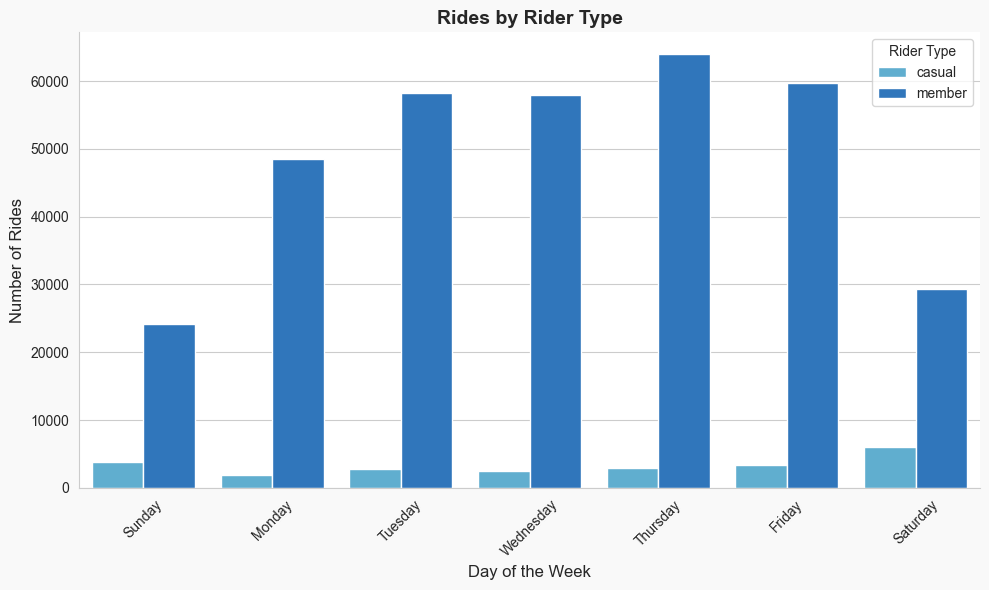

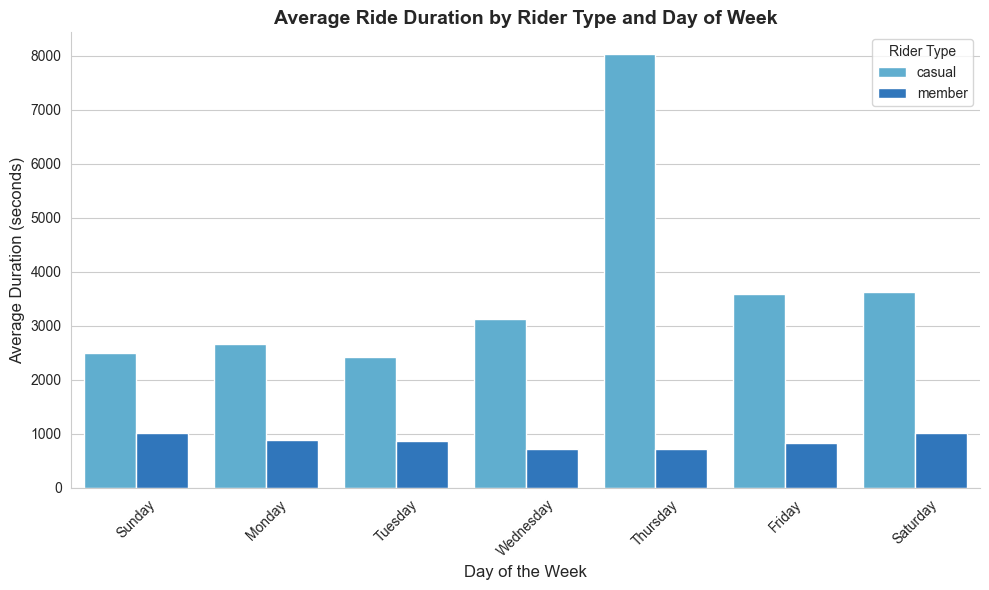

In [9]:
# Set Seaborn style
sns.set_style("whitegrid")

# Set weekday order
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Prepare ride_counts
ride_counts = all_trips_v2.groupby(["member_casual", all_trips_v2["started_at"].dt.day_name()])["ride_id"].count().reset_index(name="number_of_rides")
ride_counts["started_at"] = pd.Categorical(ride_counts["started_at"], categories=weekday_order, ordered=True)
ride_counts = ride_counts.sort_values("started_at")

# Prepare weekday_avg
weekday_avg["day_of_week"] = pd.Categorical(weekday_avg["day_of_week"], categories=weekday_order, ordered=True)
weekday_avg = weekday_avg.sort_values("day_of_week")


# Set custom palette
custom_palette = {
    "casual": "#4DB6E2",
    "member": "#1976D2"
}

# Plot
plt.figure(figsize=(10, 6))  
sns.barplot(
    data=ride_counts,
    x="started_at",
    y="number_of_rides",
    hue="member_casual",
    palette=custom_palette
)
plt.title("Rides by Rider Type", fontsize=14, weight='bold')  # Short title
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Number of Rides", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Rider Type")
sns.despine()  # Remove top and right border

# Set figure background color
plt.gcf().set_facecolor('#F9F9F9')  # gcf = get current figure
plt.tight_layout()
plt.show()

# Plot: Average Ride Duration by Rider Type and Weekday
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_avg, x="day_of_week", y="ride_length", hue="member_casual", palette=custom_palette)
plt.title("Average Ride Duration by Rider Type and Day of Week", fontsize=14, weight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Duration (seconds)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Rider Type")
sns.despine()
plt.tight_layout()
plt.show()

In [13]:
ride_counts.to_csv("ride_counts.csv", index=False)